# Fine-tuning CryptoBERT for sentiment analysis

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm

ABSOLUTE_PATH = "/content/drive/My Drive/Colab Notebooks"
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3

## Load the preprocessed data

In [8]:
test_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_test.csv")
train_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_train.csv")
val_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_val.csv")

train_df = pd.read_csv(train_set_path)
val_df = pd.read_csv(val_set_path)
test_df = pd.read_csv(test_set_path)

## Load the model and tokenizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Calculate class weights to handle imbalance

In [10]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

for i, weight in enumerate(class_weights):
    print(f"Class {i}: {weight:.4f}")

Class 0: 1.4893
Class 1: 1.2778
Class 2: 0.6469


## Training

In [11]:
target_names = ['Negative', 'Neutral', 'Positive']

def predict_sentiment(texts, model, tokenizer, batch_size=16):
    model.eval()
    predictions = []

    # Process data in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()

        # Tokenize
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            predictions.extend(preds)

    return predictions


def finetune(model, train_df, val_df, class_weights, epochs=3, batch_size=16, learning_rate=2e-5):
    train_losses, val_accuracies = [], []

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Create batches
        indices = np.random.permutation(len(train_df))
        num_batches = len(indices) // batch_size

        progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}")

        for i in progress_bar:
            # Get batch indices
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_texts = train_df.iloc[batch_indices]['full_text'].tolist()
            batch_labels = torch.tensor(train_df.iloc[batch_indices]['label'].values).to(device)

            # Tokenize
            encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss with class weights
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # Calculate average training loss for this epoch
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        model.eval()
        val_preds = predict_sentiment(val_df['full_text'], model, tokenizer, batch_size)
        val_accuracy = accuracy_score(val_df['label'].values, val_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Avg. Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

Epoch 1/3: 100%|██████████| 747/747 [04:49<00:00,  2.58it/s, loss=0.428]


Epoch 1/3 - Avg. Train Loss: 0.5843, Val Accuracy: 0.7773


Epoch 2/3: 100%|██████████| 747/747 [04:49<00:00,  2.58it/s, loss=0.292]


Epoch 2/3 - Avg. Train Loss: 0.3807, Val Accuracy: 0.8161


Epoch 3/3: 100%|██████████| 747/747 [04:49<00:00,  2.58it/s, loss=0.136]


Epoch 3/3 - Avg. Train Loss: 0.2305, Val Accuracy: 0.8201


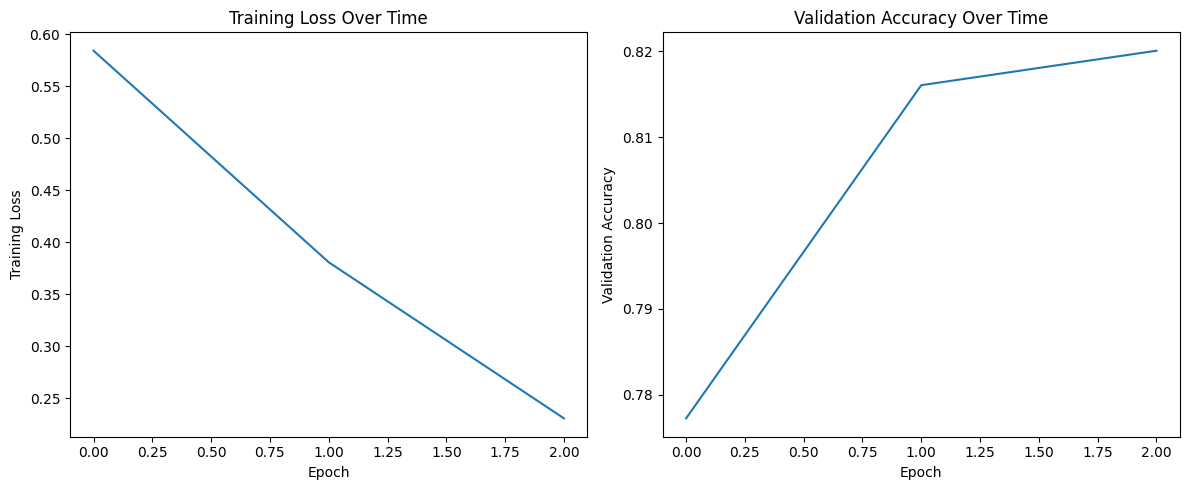

In [12]:
# Reset model to ensure we're starting fresh
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

train_losses, val_accuracies = finetune(
    model=model,
    train_df=train_df,
    val_df=val_df,
    class_weights=class_weights,
    epochs=3,
    batch_size=16,
    learning_rate=2e-5
)

# Plot training process
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Time')
plt.tight_layout()
plt.show()

## Evaluation

### Validation set

Accuracy on the validation set: 0.8201

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.78      0.82       335
     Neutral       0.65      0.75      0.70       390
    Positive       0.91      0.88      0.89       770

    accuracy                           0.82      1495
   macro avg       0.80      0.80      0.80      1495
weighted avg       0.83      0.82      0.82      1495



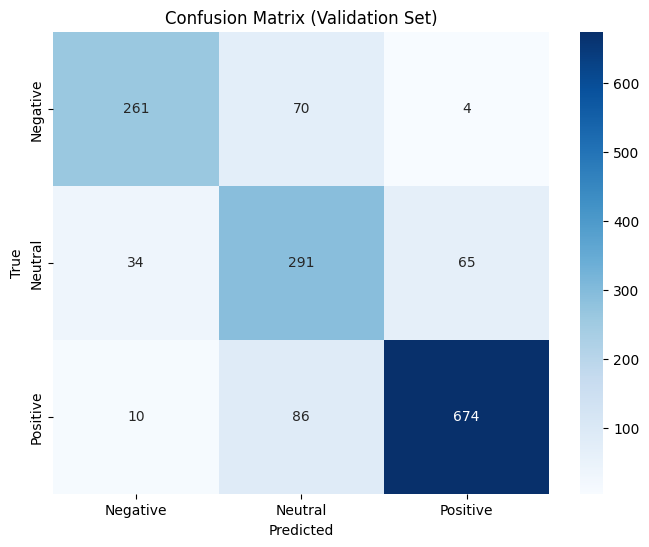

In [14]:
fine_tuned_preds = predict_sentiment(val_df['full_text'], model, tokenizer)
fine_tuned_accuracy = accuracy_score(val_df['label'].values, fine_tuned_preds)
print(f"Accuracy on the validation set: {fine_tuned_accuracy:.4f}")

# Show classification report
print("\nClassification Report:")
print(classification_report(val_df['label'].values, fine_tuned_preds, target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(val_df['label'].values, fine_tuned_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

### Test set

Accuracy on the test set: 0.8321

Test Set Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.80      0.83       334
     Neutral       0.67      0.76      0.71       390
    Positive       0.92      0.88      0.90       771

    accuracy                           0.83      1495
   macro avg       0.82      0.81      0.81      1495
weighted avg       0.84      0.83      0.84      1495



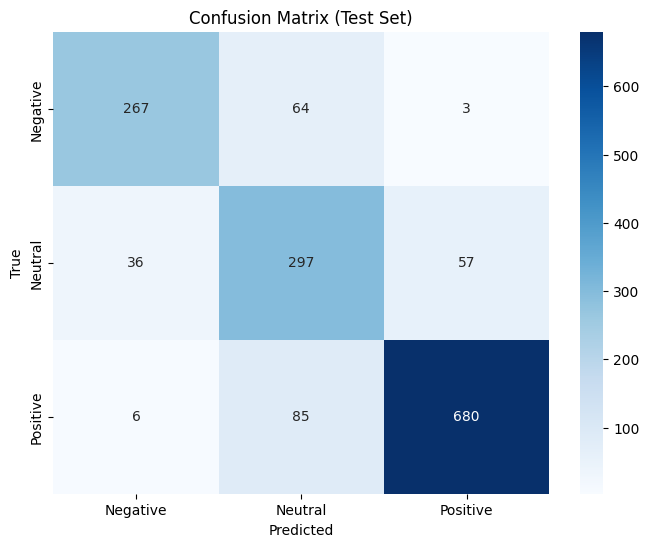

In [15]:
test_preds = predict_sentiment(test_df['full_text'], model, tokenizer)
test_accuracy = accuracy_score(test_df['label'].values, test_preds)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

# Show detailed classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(test_df['label'].values, test_preds, target_names=target_names))

# Create confusion matrix for test set
cm_test = confusion_matrix(test_df['label'].values, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

## Export the fine-tuned model

In [22]:
output_dir = os.path.join(ABSOLUTE_PATH, "models/finetuned_cryptobert/")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/drive/My Drive/Colab Notebooks/models/finetuned_cryptobert/
